# PWSkills Internship Project - Disease Recognition Using X-Ray Plates

# <font color= red> Module #1: Model Ingestion and Transformation

## Getting data directly from Kaggle

In [2]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!touch ~/.kaggle/kaggle.json

In [4]:
api_token = {"username":"aravinds93","key":"a1f087a57ff558d4655236dc4f54c7ca"}

In [5]:
# writing my API token to the kaggle.json file
import json 

with open('/root/.kaggle/kaggle.json','w') as file:
    json.dump(api_token,file)

### Downloading the dataset

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

100%|█████████████████████████████████████▉| 2.29G/2.29G [02:31<00:00, 16.8MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [02:31<00:00, 16.2MB/s]


In [11]:
import zipfile
with zipfile.ZipFile('./chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [21]:
# Let us create a function to open a random image in the dataset to see if we are working with a workable dataset

import glob
import random
import matplotlib.pyplot as plt



def get_random_image(dir,condition):
    placeholder=''
    if condition == 'n':
        placeholder='NORMAL'
    elif condition == 'p':
        placeholder='PNEUMONIA'
    else:
        raise Exception("Sorry, invalid condition")
    folder=f'./data/chest_xray/{dir}/{placeholder}/*.jpeg'
    img_paths=glob.glob(folder)
    max_length=len(img_paths)
    randomNumber=random.randint(0,max_length)
    for index, item in enumerate(img_paths, start=1):
        if index == randomNumber:
            print(index,item)
            image = plt.imread(item)
            readyImage=plt.imshow(image)
            return readyImage

2 ./data/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg


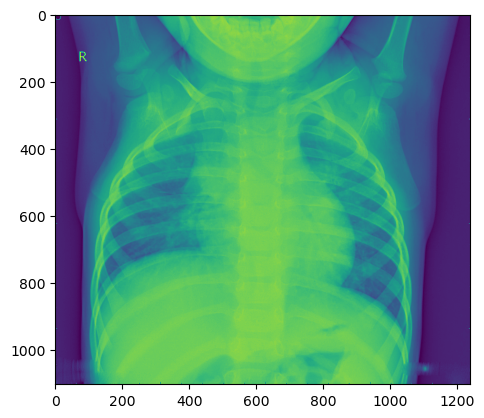

In [22]:
# Let us keep executing the function to see if we are all set with regards to the dataset
get_random_image("val","n")

1) The original images are in gray-scale.

2) This is because Matplotlib, by default opens and loads images in "viridis" (dark purple to right yellow band). So we need to save them in gray-scale format.

In [20]:
from PIL import Image

image = Image.open('data/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')  
print(image.format)
print(image.size)
print(image.mode)

JPEG
(1564, 1302)
L


1) Here, we can see that the images are in the gray-scale indicated by the image mode "L". This means that the images have 2 dimensions. However, we need our images to have 3 dimensions which is a requirement for the image classifier algorithm


2) We can also see that the images are much larger than the 224x224 which is the requirement for the in-built image classifier.

In [23]:
import PIL.Image

rgba_image=PIL.Image.open('data/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')
rgb_image=rgba_image.convert('RGB')
print(rgb_image.mode)

RGB


In [24]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#img = mpimg.imread('')
#imgplot = plt.imshow(img)
#plt.show()

## Resizing all images in the dataset and saving them in the correct gray-scale mode

In [25]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

folder=f'./data/chest_xray/train/*/*.jpeg'

counterPneu=0
counterNormal=0

img_paths=glob.glob(folder)

for i in img_paths:
    # In the datset, images with pneumonia all have the file names contain "person" in them.
    if "person" in i:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/train' + '/train_pneumonia' + str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        counterPneu+=1
    else:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/train' + '/train_normal' + str(counterNormal)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        counterNormal+=1

In [26]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

folder=f'./data/chest_xray/test/*/*.jpeg'

counterPneu=0
counterNormal=0

img_paths=glob.glob(folder)

for i in img_paths:
    if "person" in i:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/test' + '/test_pneumonia' + str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        # Here, it is important that we save the images in gray-scale using the "gray" as cmap attribute
        counterPneu+=1
    else:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/test' + '/test_normal' + str(counterNormal)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        counterNormal+=1

In [27]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

folder=f'./data/chest_xray/val/*/*.jpeg'

counterPneu=0
counterNormal=0

img_paths=glob.glob(folder)

for i in img_paths:
    if "person" in i:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/val' + '/val_pneumonia' + str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        counterPneu+=1
    else:
        full_size_image=Image.open(i)
        im=full_size_image.resize((224,224))
        plt.imsave(fname='./data/chest_xray/val' + '/val_normal' + str(counterNormal)+'.jpeg',arr=im,format='jpeg',cmap='gray')
        counterNormal+=1

#### At this point, we have resized all images to 224x224 and with the appropriate color coding of gray-scale.

#### Now, I am going to delete the original files because we created a modified copy of them in each folder in the dataset

## Creating a dataframe of all the images with appropriate classifications

In [7]:
import glob
import pandas as pd

folder=f'./data/chest_xray/*/*.jpeg'

category=[]
filenames=[]
condition_of_lung=[]

all_files=glob.glob(folder)

for filename in all_files:
    if "train" in filename:
        if "pneumonia" in filename:
            category.append("train")
            filenames.append(filename)
            condition_of_lung.append("pneumonia")
        elif "normal" in filename:
            category.append("train")
            filenames.append(filename)
            condition_of_lung.append("normal")
    elif "test" in filename:
        if "pneumonia" in filename:
            category.append("test")
            filenames.append(filename)
            condition_of_lung.append("pneumonia")
        elif "normal" in filename:
            category.append("test")
            filenames.append(filename)
            condition_of_lung.append("normal")
    elif "val" in filename:
        if "pneumonia" in filename:
            category.append("val")
            filenames.append(filename)
            condition_of_lung.append("pneumonia")
        elif "normal" in filename:
            category.append("val")
            filenames.append(filename)
            condition_of_lung.append("normal")

all_data_df=pd.DataFrame({"dataset type":category,"x-ray result":condition_of_lung,"filename":filenames})

print(all_data_df.head())

  dataset type x-ray result                                       filename
0         test       normal       ./data/chest_xray/test/test_normal4.jpeg
1         test    pneumonia    ./data/chest_xray/test/test_pneumonia1.jpeg
2         test    pneumonia  ./data/chest_xray/test/test_pneumonia359.jpeg
3         test    pneumonia  ./data/chest_xray/test/test_pneumonia197.jpeg
4         test       normal     ./data/chest_xray/test/test_normal103.jpeg


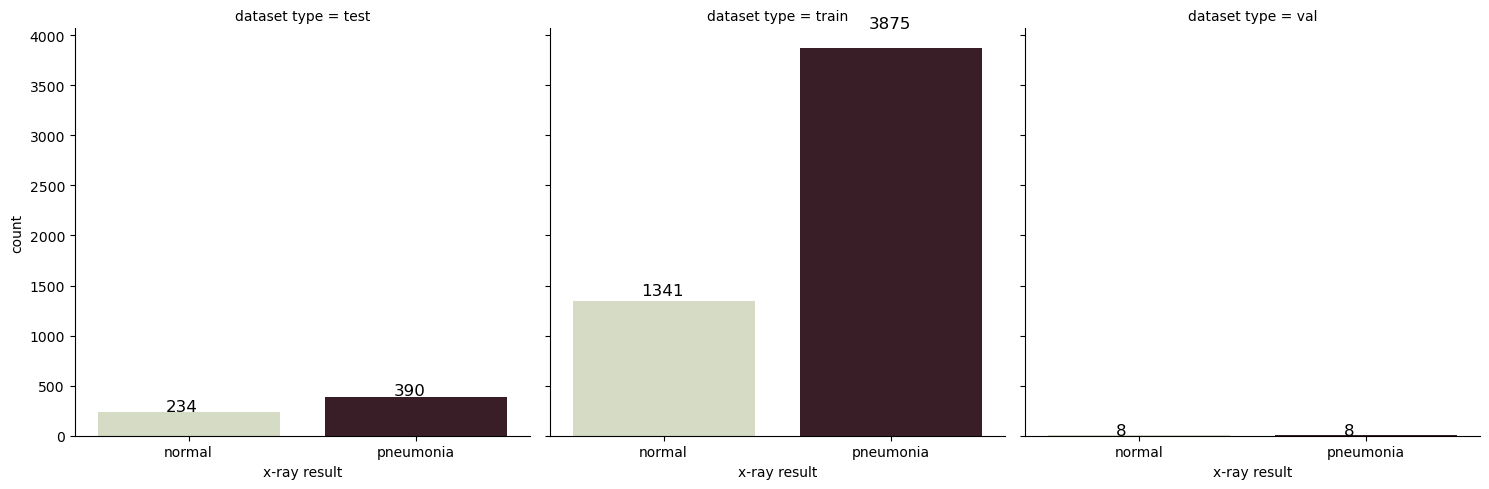

In [8]:
# Data visualization
import seaborn as sns

g=sns.catplot(x="x-ray result",col="dataset type",kind="count",palette="ch:.55",data=all_data_df,legend=True)

for i in range(0,3):
    ax=g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x()+0.3,
        p.get_height()*1.05,
        '{0:.0f}'.format(p.get_height()),
        color='black',
        rotation='horizontal',
        size='large')

In [10]:
print(" test imbalance",100-(234/390*100),"%\n train imbalance", round(100-(1341/3875*100),1), "%\n val imbalance", 100-(8/8*100),"%")

 test imbalance 40.0 %
 train imbalance 65.4 %
 val imbalance 0.0 %


1) There is a moderate class imbalance in the dataset with more no. of images that contain the disease rather than without.

## Creation of train and test dataset of the resized images

In [11]:
import glob
import pandas as pd
import os
train_folder='./data/chest_xray/train/*.jpeg'
train_df_lst=pd.DataFrame(columns=['labels','s3_path'],dtype=object)
train_imgs_path=glob.glob(train_folder)
counter=0
class_arg=''

for i in train_imgs_path:
    if "pneumonia" in i:
        class_arg=1
    else:
        class_arg=0
    train_df_lst.loc[counter]=[class_arg,os.path.basename(i)]
    counter+=1
print(train_df_lst.head())

   labels                   s3_path
0       0     train_normal1203.jpeg
1       1  train_pneumonia3349.jpeg
2       1   train_pneumonia478.jpeg
3       1  train_pneumonia1567.jpeg
4       1  train_pneumonia2296.jpeg


In [13]:
import glob
import pandas as pd
import os
test_folder='./data/chest_xray/test/*.jpeg'
test_df_lst=pd.DataFrame(columns=['labels','s3_path'],dtype=object)
test_imgs_path=glob.glob(test_folder)
counter=0
class_arg=''

for i in test_imgs_path:
    if "pneumonia" in i:
        class_arg=1
    else:
        class_arg=0
    test_df_lst.loc[counter]=[class_arg,os.path.basename(i)]
    counter+=1
print(test_df_lst.head())

   labels                 s3_path
0       0       test_normal4.jpeg
1       1    test_pneumonia1.jpeg
2       1  test_pneumonia359.jpeg
3       1  test_pneumonia197.jpeg
4       0     test_normal103.jpeg


1) Here, pandas automatically creates an index column.

## Creation of "train.lst" and "test.lst" files with tab delimiter - a standard input format for the image processing algorithm

In [14]:
def save_to_lst(df,prefix):
    return df[["labels","s3_path"]].to_csv(
    f"{prefix}.lst", sep='\t',index=True,header=False
    )

save_to_lst(train_df_lst.copy(),"train")
save_to_lst(test_df_lst.copy(),"test")

## Created an S3 bucket with default settings and name "aravind-internship-pneumoniadetection". Creating the variables with this bucket's properties below

In [2]:
bucket='aravind-internship-pneumoniadetection'
print("bucket:{}".format(bucket))
region='ap-south-1'
print("region:{}".format(region))
roleArn='arn:aws:s3:::aravind-internship-pneumoniadetection'
print("roleArn:{}".format(roleArn))

bucket:aravind-internship-pneumoniadetection
region:ap-south-1
roleArn:arn:aws:s3:::aravind-internship-pneumoniadetection


## Setting up the environment

In [3]:
import os

os.environ["DEFAULT_S3_BUCKET"]=bucket

## Running shell commands to import the train and test datasets/folders to the S3 bucket

In [17]:
!aws s3 sync ./data/chest_xray/train s3://${DEFAULT_S3_BUCKET}/train/

upload: data/chest_xray/train/.ipynb_checkpoints/train_normal10-checkpoint.jpeg to s3://aravind-internship-pneumoniadetection/train/.ipynb_checkpoints/train_normal10-checkpoint.jpeg
upload: data/chest_xray/train/train_normal1000.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal1000.jpeg
upload: data/chest_xray/train/train_normal1.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal1.jpeg
upload: data/chest_xray/train/train_normal1005.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal1005.jpeg
upload: data/chest_xray/train/train_normal10.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal10.jpeg
upload: data/chest_xray/train/train_normal0.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal0.jpeg
upload: data/chest_xray/train/train_normal1006.jpeg to s3://aravind-internship-pneumoniadetection/train/train_normal1006.jpeg
upload: data/chest_xray/train/train_normal1007.jpeg to s3://aravind-internship

In [18]:
!aws s3 sync ./data/chest_xray/test s3://${DEFAULT_S3_BUCKET}/test/

upload: data/chest_xray/test/test_normal0.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal0.jpeg
upload: data/chest_xray/test/test_normal106.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal106.jpeg
upload: data/chest_xray/test/test_normal1.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal1.jpeg
upload: data/chest_xray/test/test_normal11.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal11.jpeg
upload: data/chest_xray/test/test_normal10.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal10.jpeg
upload: data/chest_xray/test/test_normal103.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal103.jpeg
upload: data/chest_xray/test/test_normal109.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal109.jpeg
upload: data/chest_xray/test/test_normal100.jpeg to s3://aravind-internship-pneumoniadetection/test/test_normal100.jpeg
upload: data/chest_xray/test/test_normal110.jpeg to 

# <font color= red> Module #2: Model training and evaluation

## Importing ".lst" files to the S3 bucket

In [19]:
import boto3

boto3.Session().resource("s3").Bucket(bucket).Object("train.lst").upload_file("./train.lst")
boto3.Session().resource("s3").Bucket(bucket).Object("test.lst").upload_file("./test.lst")

## Setting up estimator object which is going contain the algorithm docker image for the image classifier from the Amazon Elastic Container Registry

In [4]:
bucket='aravind-internship-pneumoniadetection'
print("bucket:{}".format(bucket))
region='ap-south-1'
print("region:{}".format(region))
roleArn='arn:aws:s3:::aravind-internship-pneumoniadetection'
print("roleArn:{}".format(roleArn))

bucket:aravind-internship-pneumoniadetection
region:ap-south-1
roleArn:arn:aws:s3:::aravind-internship-pneumoniadetection


In [5]:
import sagemaker
from sagemaker import image_uris, get_execution_role
import boto3
sess = sagemaker.Session()

algorithm_image = image_uris.retrieve(region = boto3.Session().region_name, framework = "image-classification")

s3_output_location = f's3://{bucket}/models/image_model'
print(algorithm_image)
                                      

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
991648021394.dkr.ecr.ap-south-1.amazonaws.com/image-classification:1


In [6]:
role = get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
arn:aws:iam::583278329734:role/service-role/AmazonSageMaker-ExecutionRole-20230917T202848


In [52]:
image_classifier_model = sagemaker.estimator.Estimator(algorithm_image, 
                                                       role=role,
                                                       instance_count=1,
                                                       instance_type="ml.p2.xlarge",
                                                       volume_size = 50,
                                                       input_mode = "File",
                                                       max_run = 432000,
                                                       output_path = s3_output_location,
                                                       sagemaker_session = sess)       
print(image_classifier_model)

Here, the input_mode is given "File" mode instead of "Pipe" mode because our sample size is not too large.

## Setting up Hyperparameter tuning job

Counting how many training image file we got. This number should be equal to the barplot shown above, which is (1341+3875) = 5216

In [53]:
import glob

count = 0

for filepath in glob.glob("./data/chest_xray/train/*.jpeg"):
    count+=1
print(count)    

0


Now that we have all the files here, we can delete them so that the training can happen smoothly and there is no multiple dataset instances apart from the required .lst files.

In [54]:
image_classifier_model.set_hyperparameters(image_shape = '3,224,224',
                                         num_classes = 2,
                                         use_pretrained_model = 1,
                                         num_training_samples = 5216,
                                         augmentation_type = "crop_color_transform",
                                         epochs = 15,
                                         early_stopping = True,
                                         early_stopping_min_epochs = 8,
                                         early_stopping_tolerance = 0.0,
                                         early_stopping_patience = 5,
                                         lr_scheduler_factor = 0.1,
                                         lr_scheduler_step = "8,10,12")

## Specifying dynamic hyperparameters we want to tune

In [55]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {"learning_rate":ContinuousParameter(0.01,0.1),
                         "mini_batch_size":CategoricalParameter([8,16,32]),
                         "optimizer":CategoricalParameter(["sgd" ,"adam"])}

## Setting up the training job

In [56]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"
max_jobs = 5
max_parallel_jobs = 1

1) No parallel jobs are done here not only because it is cheaper, but also because the Baesian Search takes into consideration all that the model has learned since the training start. This will not apply if parallel jobs are executed.

In [57]:
tuner = HyperparameterTuner(estimator = image_classifier_model,
                            objective_metric_name = objective_metric_name,
                            hyperparameter_ranges = hyperparameter_ranges,
                            objective_type = objective_type,
                            max_jobs = max_jobs,
                            max_parallel_jobs = max_parallel_jobs)

### Specifying where the model inputs are, and naming the training jobs

In [58]:
from sagemaker.session import TrainingInput

model_inputs = {"train": sagemaker.inputs.TrainingInput(s3_data = f"s3://{bucket}/train/", content_type = "application/x-image"),
                "validation": sagemaker.inputs.TrainingInput(s3_data = f"s3://{bucket}/test/", content_type = "application/x-image"),
                "train_lst": sagemaker.inputs.TrainingInput(s3_data = f"s3://{bucket}/train.lst", content_type = "application/x-image"),
                "validation_lst": sagemaker.inputs.TrainingInput(s3_data = f"s3://{bucket}/test.lst", content_type = "application/x-image")
               }

In [59]:
import time

job_name_prefix = "classifier"
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S",time.gmtime())
job_name = job_name_prefix + timestamp

In [60]:
tuner.fit(inputs = model_inputs, job_name = job_name, logs = True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

#### Inferences

1) The hyperparameter tuning was successful and the five training jobs were completed in ~7 hours. 
2) Name: "classifier-2023-09-21-03-58-24-005-47430480" was found to be the best model with 85% accuracy.
3) Since this is a self-funded internship project, only 15 epochs were used. However, if funded by the company, the epochs can be increased to 50, which is the industrial standard.

## Creating an Endpoint to access the best model: Local Model Deployment

In [7]:
import sagemaker
from sagemaker import get_execution_role

In [8]:
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [9]:
model = sagemaker.model.Model(image_uri = algorithm_image,
                              model_data = 's3://aravind-internship-pneumoniadetection/models/image_model/classifier-2023-09-21-03-58-24-005-47430480/output/model.tar.gz',
                              role = role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [10]:
endpoint_name = 'MLInternship-PneumoniaDetection'

In [11]:
deployment = model.deploy(initial_instance_count = 1,
                         instance_type = 'ml.m4.xlarge',
                         endpoint_name = endpoint_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
-------------!

Model was deployed successfully. The endpoint was found to be under the "Endpoints" section of Sagemaker

In [18]:
from sagemaker.predictor import Predictor
predictor = Predictor("MLInternship-PneumoniaDetection")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [19]:
from sagemaker.serializers import IdentitySerializer
import base64

file_name = "data/chest_xray/val/val_normal0.jpeg"

predictor.serializer = IdentitySerializer("image/jpeg")

with open(file_name,"rb") as f:
    payload = f.read()
    
inference = predictor.predict(data = payload)
print(inference)

b'[0.9988318085670471, 0.0011682442855089903]'


#### Inference: The model has predicted with 99.88% accuracy that this is class "a", which is normal x-ray.

In [20]:
from sagemaker.serializers import IdentitySerializer
import base64

file_name = "data/chest_xray/val/val_pneumonia0.jpeg"

predictor.serializer = IdentitySerializer("image/jpeg")

with open(file_name,"rb") as f:
    payload = f.read()
    
inference = predictor.predict(data = payload)
print(inference)

b'[0.029693154618144035, 0.9703068137168884]'


Here, the o/p is a byte array and hence we cannot extract individual probabilities without deserializing the byte array

#### Inference: Model has predicted with 97% accuracy that this is class "b", which is x-ray with pneumonia

## Constructing Confusion matrix and creating model evaluation using metrics

In [21]:
# Creating a function to run prediction on all validation images(dataset)
import glob
import json
import numpy as np

file_path = "data/chest_xray/val/*.jpeg"
files = glob.glob(file_path)

y_true = []
y_pred = []

def make_pred():
    for file in files:
        if "normal" in file:
            with open(file,"rb") as f:
                payload = f.read()
                inference = predictor.predict(data = payload).decode("utf-8")
                result = json.loads(inference)
                predicted_class = np.argmax(result)
                y_true.append(0) #Normal x-rays are class "0"
                y_pred.append(predicted_class)
        elif "pneumonia" in file:
            with open(file,"rb") as f:
                payload = f.read()
                inference = predictor.predict(data = payload).decode("utf-8")
                result = json.loads(inference)
                predicted_class = np.argmax(result)
                y_true.append(1) #Pneumonia infected x-rays are class "1"
                y_pred.append(predicted_class)

make_pred()
print("Actual:", y_true)
print("Predicted:", y_pred)

Actual: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
Predicted: [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]


#### Inference: Except 3rd instance, all others were successfully predicted.

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_pred)

array([[7, 1],
       [0, 8]])

#### Inferences: 
1) Here, we have 1 false positive. The x-ray was detected to have pneumonia but in reality the x-ray didn't.
2) Here, we have 0 false negatives. This means, no x-ray with infection went undetected/classified as normal.

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



#### Inferences:
1) In medical predictions, recall is to be maximized, since it deals with False Negatives. Here, we have max recall value for class "1". This is the ideal condition. For class "0" recall is 88%. This is also acceptable.
2) These metrics are great indicating that this model can be deployed in production.

# <font color= red> Module #3: Model deployment

Activate endpoint -> Lambda Function